# Week 11 - Introduction to Modeling, part 2

# 1. Lesson - No lesson this week

# 2. Weekly graph question

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

The book names one of Vonnegut's rules as "keep it simple" and another as "have the guts to cut."  Here is some data from the previous week's lesson.  If you had to cut one of the two plots below, which would it be?  Which seems more interesting or important?  Explain.  (Should "amount of training data used" or "number of estimators" be on the x-axis.)

In [2]:
np.random.seed(0)
num_points = 10000
feature_1a = np.random.random(size = num_points) * 3
feature_2a = np.random.random(size = num_points) * 3
feature_3a = np.random.random(size = num_points) * 3
train_target = (feature_1a - 2 * feature_2a) * feature_3a + np.random.normal(size = num_points)
feature_1b = np.random.random(size = num_points) * 3
feature_2b = np.random.random(size = num_points) * 3
feature_3b = np.random.random(size = num_points) * 3
test_target = (feature_1b - 2 * feature_2b) * feature_3b + np.random.normal(size = num_points)
train_df = pd.DataFrame({"f1": feature_1a, "f2": feature_2a, "f3": feature_3a})
test_df = pd.DataFrame({"f1": feature_1b, "f2": feature_2b, "f3": feature_3b})
rf = RandomForestRegressor()
rf.fit(train_df.values, train_target)

RandomForestRegressor()

In [3]:
rmse_lst = list()
rf = RandomForestRegressor()
for x in range(round(num_points / 20), num_points, round(num_points / 20)):
    rf.fit(train_df.values[0:x,:], train_target[0:x])
    rmse_lst.append(root_mean_squared_error(rf.predict(test_df.values), test_target))

import matplotlib.pyplot as plt

Text(0, 0.5, 'Loss function')

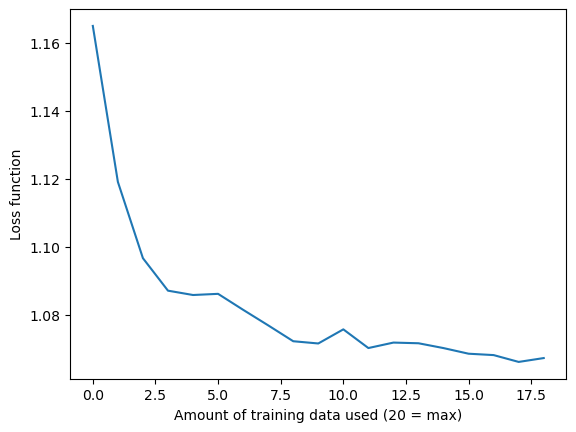

In [4]:
plt.plot(rmse_lst)
plt.xlabel("Amount of training data used (20 = max)")
plt.ylabel("Loss function")

In [5]:
num_trees_lst = list()
for n_estimators in range(1, 100, 3):
    rf = RandomForestRegressor(n_estimators = n_estimators)
    rf.fit(train_df.values, train_target)
    num_trees_lst.append(root_mean_squared_error(rf.predict(test_df.values), test_target))

Text(0, 0.5, 'Loss function')

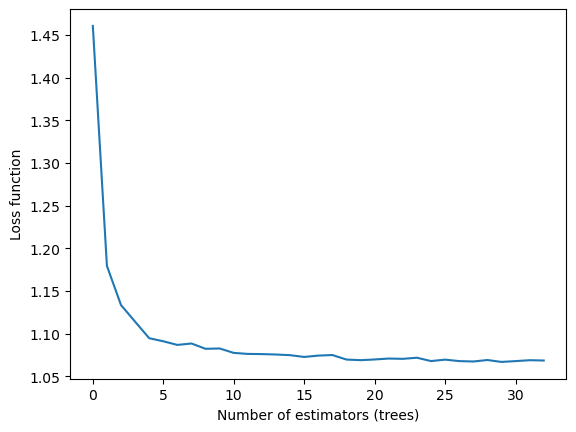

In [6]:
plt.plot(num_trees_lst)
plt.xlabel("Number of estimators (trees)")
plt.ylabel("Loss function")

For the plots above, I would chose to cut the plot with number of estimators (trees) as the x-axis if I was presenting my findings. Plotting loss vs. number of trees is useful when tuning your model and finding the right parameter metric to get the best performance; however, this would be unneccesary when presenting your results since this is an internal step in the overall process of training a model. The plot of loss vs. amount of training data used is better for showing general trends that would be more interesting to your audience. From this plot, you can see signs of overfitting or underfitting and check wether the model converged.

# 3. Working on your datasets

This week, you will do the same types of exercises as last week, but you should use your chosen datasets that someone in your class found last semester. (They likely will not be the particular datasets that you found yourself.)

Here are some types of analysis you can do:

* Implement a random forest model.
* Perform cross-validation.
* Tune hyperparameters.
* Evaluate a performance metric.

If you like, you can try other types of models, too (beyond linear regression and random forest) although you will have many opportunities to do that next semester.

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import (train_test_split,
                                     cross_val_score,
                                     RepeatedKFold
                                     )
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import kagglehub
import os

In [8]:
def run_model(model, X_train, y_train, X_test, y_test, n_repeats=10, n_jobs=-1, **model_params):

    # Instantiate the model if a class is provided, so for example can use either BaggingRegressor or BaggingRegressor() as argument. 
    if isinstance(model, type):
        model = model(**model_params)

    neg_mse_scores = cross_val_score(model, X_train, y_train,scoring = 'neg_mean_squared_error',
                                     cv = RepeatedKFold(n_splits=5, n_repeats=n_repeats, random_state=42), n_jobs  = n_jobs)
    
    mean_cv_mse = -np.mean(neg_mse_scores)
    std_cv_mse  = np.std(neg_mse_scores)
    
    # Fit the model on the full training set
    model.fit(X_train, y_train)
    
    # Compute training MSE and testing MSE
    train_preds = model.predict(X_train)
    train_mse   = mean_squared_error(y_train, train_preds)
    test_preds  = model.predict(X_test)
    test_mse    = mean_squared_error(y_test, test_preds)
    
    return mean_cv_mse, std_cv_mse, train_mse, test_mse

In [9]:
def load_Kaggle_dataset(kaggle_path, kaggle_filename, index_col=0):

    # Download latest version
    path = kagglehub.dataset_download(kaggle_path)
    print("Path to dataset files:", path)

    # Load the data into a DataFrame
    csv_path = os.path.join(path, kaggle_filename)
    raw_data = pd.read_csv(csv_path, index_col=index_col)

    return raw_data

In [10]:
# Load raw data from Kagglehub
phishing = load_Kaggle_dataset('shashwatwork/web-page-phishing-detection-dataset', 'dataset_phishing.csv', index_col=None)

Path to dataset files: /Users/rosemarydabbs/.cache/kagglehub/datasets/shashwatwork/web-page-phishing-detection-dataset/versions/2


In [11]:
# Encode status column
one_hot = pd.get_dummies(phishing["status"])
phishing_encoded = phishing.join(one_hot).copy()

# Convert to integers
phishing_encoded[['legitimate','phishing']] = phishing_encoded[['legitimate','phishing']].astype(int)

In [12]:
# Remove unneccessary identifying columns and separate target/features for modeling
X = phishing_encoded.drop(columns=['url', 'status', 'phishing', 'legitimate'])
y = phishing_encoded['legitimate']

# Create train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Select only numeric features for PCA
phishing_numeric = X.select_dtypes(include=['number'])

In [13]:
cv_mse, std_cv, train_mse, test_mse = run_model(model=RandomForestRegressor(),
                                                X_train=X_train,
                                                y_train=y_train,
                                                X_test=X_test,
                                                y_test=y_test,
                                                n_repeats=5,
                                                n_jobs=-1
                                                )

In [14]:
gcv = GridSearchCV(estimator = RandomForestRegressor(), param_grid = {"n_estimators": [10, 33, 100], "max_depth": [2, 4, None]}, \
                   scoring = "neg_root_mean_squared_error")
gcv.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_depth': [2, 4, None],
                         'n_estimators': [10, 33, 100]},
             scoring='neg_root_mean_squared_error')

In [15]:
print(gcv.best_estimator_)
print(gcv.best_params_)
print(gcv.best_score_)

RandomForestRegressor()
{'max_depth': None, 'n_estimators': 100}
-0.1864135615702828


# 4. Storytelling With Data plot

Reproduce any graph of your choice in chapter seven (p. 165-185) of the Storytelling With Data book as best you can. You do not have to get the exact data values right, just the overall look and feel.

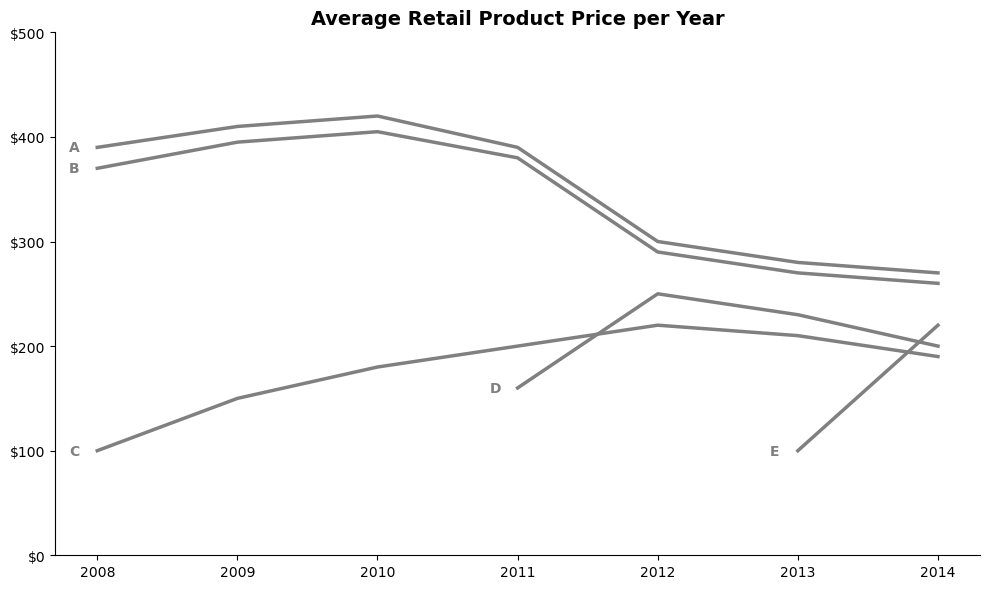

In [16]:
# --------------------------------------
# Recreation of graph from p. 193
# There are no graphs to choose in ch. 7
# --------------------------------------

import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

# Create sample data
years = [2008, 2009, 2010, 2011, 2012, 2013, 2014]
product_a = [390, 410, 420, 390, 300, 280, 270]
product_b = [370, 395, 405, 380, 290, 270, 260]
product_c = [100, 150, 180, 200, 220, 210, 190]
product_d = [None, None, None, 160, 250, 230, 200]
product_e = [None, None, None, None, None, 100, 220]

# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Define color
color='gray'

# Plot each product line
ax.plot(years, product_a, label='Product A', color=color, linewidth=2.5)
ax.plot(years, product_b, label='Product B', color=color, linewidth=2.5)
ax.plot(years, product_c, label='Product C', color=color, linewidth=2.5)
ax.plot(years, product_d, label='Product D', color=color, linewidth=2.5)
ax.plot(years, product_e, label='Product E', color=color, linewidth=2.5)

# Set title
ax.set_title('Average Retail Product Price per Year', fontsize=14, weight='bold')

# Add line labels near the starting point of each line
ax.text(2008 - 0.2, product_a[0], 'A', color=color, fontsize=10, va='center', fontweight='bold')
ax.text(2008 - 0.2, product_b[0], 'B', color=color, fontsize=10, va='center', fontweight='bold')
ax.text(2008 - 0.2, product_c[0], 'C', color=color, fontsize=10, va='center', fontweight='bold')
ax.text(2011 - 0.2, product_d[3], 'D', color=color, fontsize=10, va='center', fontweight='bold')
ax.text(2013 - 0.2, product_e[5], 'E', color=color, fontsize=10, va='center', fontweight='bold')

# Format y-axis as dollars
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))

# Set y-axis limits
ax.set_ylim(0, 500)
ax.grid(False)

# Remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Adjust layout
plt.tight_layout()
plt.show()
